In [ ]:
#USE CONDA ENVIRONMENT WITH SKLEARN 0.21.3 and PYTHON 3.7 for REINVENT2.0 COMPATIBILITY
import os
import pandas as pd
import numpy as np
from typing import List
from rdkit import Chem
from rdkit.Chem import AllChem

from sklearn.ensemble import RandomForestClassifier

#use features as specified by FLAML
clf = RandomForestClassifier(n_estimators = 244, max_features= 0.022097086912079608, 
max_leaf_nodes=12603, criterion='entropy')

In [ ]:
#load X and Y
DATAPATH = "../data"
DOCKING_FILE = "docking_scores_and_accessibilities_and_pocket_edist.tsv"

df = pd.read_csv(os.path.join(DATAPATH,
                              "docking/docking_MurD/structures/SagaMurD_Frag373", 
                              DOCKING_FILE),sep='\t', header=0)

def ecfp_counts(mols):
    fps = [AllChem.GetMorganFingerprint(mol, radius=3, useCounts=True, useFeatures=True) for mol in mols]
    nfp = np.zeros((len(fps), 2048), np.int32)
    for i, fp in enumerate(fps):
        for idx, v in fp.GetNonzeroElements().items():
            nidx = idx % 2048
            nfp[i, nidx] += int(v)
    return nfp


smiles = df["smiles"]
mols = [Chem.MolFromSmiles(smi) for smi in smiles]
ecfp = ecfp_counts(mols)

#Use same train/test split as in FLAML parameter optimization
with open("../models/docking_train.txt", "r") as f:
    data = f.read()
    i_train = data.replace("/n", ",").split(",")
    i_train = i_train[:-1]
i_train = [int(i) for i in i_train]

with open("../models/docking_test.txt", "r") as f:
    data = f.read()
    i_test = data.replace("/n", ",").split(",")
    i_test = i_test[:-1]
i_test = [int(i) for i in i_test]

X_train = ecfp[i_train, :]
X_test = ecfp[i_test, :]

y_train = df["class"].loc[i_train]
y_test = df["class"].loc[i_test]

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

y_pred = clf.predict_proba(X_test)


fpr_test, tpr_test, _ = metrics.roc_curve(y_test, y_pred[:,1])
auc_test = metrics.roc_auc_score(y_test, y_pred[:,1])

plt.plot(fpr_test, tpr_test, label = str(auc_test), lw=2.5, color = "#bee6b4")
plt.xlabel("False Positive Rate", fontsize =14)
plt.xticks(fontsize = 14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.yticks(fontsize = 14)
plt.title("ROC-AUC", fontsize=16)
plt.legend(loc = 'lower right')
plt.savefig(os.path.join("../figures", "roc_docking_sklearn.png"))

In [ ]:
import joblib
import pickle as pkl

joblib.dump(clf,"../models/docking_sklearn.joblib")
with open ("../models/docking_sklearn.pkl", "wb") as f:
    pkl.dump(clf, f)

# Distance to relevant datasets

In [108]:
#datasets
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem

DATAPATH = "../data"

DOCKING_FILE = "docking_scores_and_accessibilities_and_pocket_edist.tsv"

df = pd.read_csv(os.path.join(DATAPATH,
                              "docking/docking_MurD/structures/SagaMurD_Frag373", 
                              DOCKING_FILE),sep='\t', header=0)

inh = pd.read_csv(os.path.join(DATAPATH, "murD_inhibition.csv"))
pocketvec = pd.read_csv("../pocketvec/PDB/pocketvec_molecules.tsv", sep='\t', header=None) #must clean cycles

def ecfp_counts(mols):
    fps = [AllChem.GetMorganFingerprint(mol, radius=3, useCounts=True, useFeatures=True) for mol in mols]
    nfp = np.zeros((len(fps), 2048), np.int32)
    for i, fp in enumerate(fps):
        for idx, v in fp.GetNonzeroElements().items():
            nidx = idx % 2048
            nfp[i, nidx] += int(v)
    return nfp

In [109]:
#for the pocketvec molecules, eliminate the ones with low QED values
from rdkit.Chem import QED
mols_pv = [Chem.MolFromInchi(i) for i in pocketvec[1]]
mols_inh =[Chem.MolFromSmiles(s) for s in inh["SMILES"]]

qed_pv = [QED.qed(m) for m in mols_pv]
qed_inh = [QED.qed(m) for m in mols_inh]

[16:23:12] WARNING:  (Metal compound) Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Charge(s): Do not match; Proton balance: Does not match); Disconnected:  Mobile-H( Charge(s): Do not match)



(array([ 3.,  2.,  7., 10., 12., 29., 20., 28., 19., 14.]),
 array([0.02411505, 0.09742052, 0.17072599, 0.24403146, 0.31733693,
        0.3906424 , 0.46394787, 0.53725334, 0.61055881, 0.68386427,
        0.75716974]),
 <BarContainer object of 10 artists>)

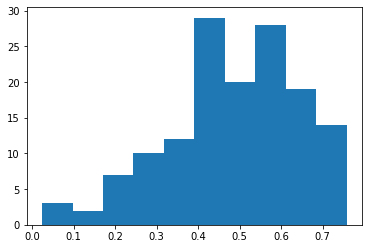

In [110]:
import matplotlib.pyplot as plt
plt.hist(qed_pv)

In [111]:
idxs = []
for i, x in enumerate (qed_pv):
    if x < 0.4:
        idxs += [i]

In [112]:
pocketvec.drop(index=idxs, axis=0, inplace=True)
pocketvec.to_csv(os.path.join(DATAPATH, "pocketvec_inchi.csv"), index=False)

In [113]:
mols_pv = [Chem.MolFromInchi(i) for i in pocketvec[1]]
ecfp_pv = ecfp_counts(mols_pv)

mols_inh =[Chem.MolFromSmiles(s) for s in inh["SMILES"]]
ecfp_inh = ecfp_counts(mols_inh)

In [114]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(ecfp_pv)

import joblib
import pickle as pkl

joblib.dump(neigh,"../models/pocketvec_neigh.joblib")
with open ("../models/pocketvec_neigh.pkl", "wb") as f:
    pkl.dump(neigh, f)

In [124]:
#check similarity to 5 closest neighbors for 1000 mols from docking dataset

test_smi = df["smiles"].loc[:1000].tolist()
test_mols = [Chem.MolFromSmiles(smi) for smi in test_smi]
test_ecfp = ecfp_counts(test_mols)

similarity = []
for i,m in enumerate(test_mols):
    kn = neigh.kneighbors(X = [test_ecfp[i]], n_neighbors=5, return_distance=True)
    near_mols_idx = kn[1][0]
    near_mols = [mols_pv[i] for i in near_mols_idx]
    fp_test = FingerprintMols.FingerprintMol(m, minPath=1, maxPath=7, fpSize=2048,
                               bitsPerHash=2, useHs=True, tgtDensity=0.0,
                               minSize=128)
    fps = [FingerprintMols.FingerprintMol(mol, minPath=1, maxPath=7, fpSize=2048,
                                bitsPerHash=2, useHs=True, tgtDensity=0.0,
                                minSize=128) for mol in near_mols]
    s = DataStructs.BulkTanimotoSimilarity(fp_test, fps)
    mean_sim = mean(s)
    similarity.append(mean_sim)

(array([136., 137., 186., 192., 157.,  88.,  65.,  20.,  16.,   4.]),
 array([0.00567414, 0.04998932, 0.0943045 , 0.13861968, 0.18293486,
        0.22725004, 0.27156522, 0.3158804 , 0.36019558, 0.40451076,
        0.44882594]),
 <BarContainer object of 10 artists>)

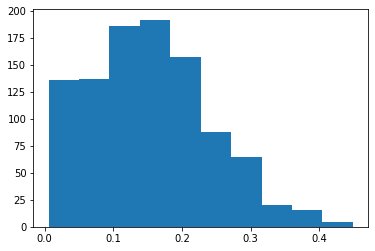

In [125]:
plt.hist(similarity)

In [93]:
test = neigh.kneighbors(X=[ecfp_inh[60]], n_neighbors=5, return_distance=True)

In [100]:
near_mols_idx = test[1][0]
near_mols = [mols_pv[i] for i in near_mols_idx]

In [107]:
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from statistics import mean

mol_test = FingerprintMols.FingerprintMol(mols_inh[60], minPath=1, maxPath=7, fpSize=2048,
                               bitsPerHash=2, useHs=True, tgtDensity=0.0,
                               minSize=128)
fps = [FingerprintMols.FingerprintMol(mol, minPath=1, maxPath=7, fpSize=2048,
                               bitsPerHash=2, useHs=True, tgtDensity=0.0,
                               minSize=128) for mol in near_mols]


s = DataStructs.BulkTanimotoSimilarity(mol_test, fps)
print(mean(s))



#for n in range(len(fps)-1):
 #   s = DataStructs.BulkTanimotoSimilarity(fps[n], fps[n+1:])

0.1510153572409024


In [92]:
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols


fps = [FingerprintMols.FingerprintMol(mol, minPath=1, maxPath=7, fpSize=2048,
                               bitsPerHash=2, useHs=True, tgtDensity=0.0,
                               minSize=128) for mol in mols_pv]

for n in range(len(fps)-1):
    s = DataStructs.BulkTanimotoSimilarity(fps[n], fps[n+1:])

[0.07942973523421588, 0.15869017632241814, 0.11852861035422343, 0.06336088154269973, 0.1087378640776699, 0.09531772575250837, 0.13679890560875513, 0.032432432432432434, 0.07010309278350516, 0.0856353591160221, 0.0856353591160221, 0.01440922190201729, 0.05930470347648262, 0.07526881720430108, 1.0, 0.005714285714285714, 0.020289855072463767, 0.0028653295128939827, 0.14964788732394366, 0.0389908256880734, 0.07956600361663653, 0.15476190476190477, 0.15384615384615385, 0.06178489702517163, 0.104, 0.17697228144989338, 0.04081632653061224, 0.047619047619047616, 0.02, 0.044534412955465584, 0.043233082706766915, 0.052980132450331126, 0.05089058524173028, 0.04888888888888889, 0.14901960784313725, 0.07183364839319471, 0.10133843212237094, 0.08947368421052632, 0.07969639468690702, 0.1489071038251366, 0.12397540983606557, 0.10311284046692606, 0.06557377049180328, 0.15768056968463887, 0.15352260778128285, 0.12622549019607843, 0.061601642710472276, 0.014577259475218658, 0.1330891330891331, 0.15958451

In [ ]:
from rdkit import Chem, AllChem
from rdkit import DataStructs
class DistanceToDataset():

    def __init__(mols):
        self.mols=mols

    def ecfp_counts(self):
        fps = [AllChem.GetMorganFingerprint(mol, radius=3, useCounts=True, useFeatures=True) for mol in self.mols]
        self.nfp = np.zeros((len(fps), 2048), np.int32)
        for i, fp in enumerate(fps):
            for idx, v in fp.GetNonzeroElements().items():
                nidx = idx % 2048
                self.nfp[i, nidx] += int(v)
        return self.nfp
    
    def knear(self, mol):
        

    def tanimoto(self, mol):
        for n in range()